# Implement the (inexact) Newton method without inverting the Hessian, but using the conjugate gradient method. Evaluate the effect of stopping the conjugate method after i ≤ d steps, where d is the dimension of the parameter vector. See Bottou et al section 6.1 and Bubeck section 2.4.

* implement method 
* check that it does not work good with sgd only with fb
* The savings in computation come at the expense of storage of some additional quantities, as explained in Example 6.1.

* create function and check that 2nd order method is highly attracted by saddle points
* see dependence of attraction and number of iterations of conjugate gradient 
* try to optimize svm in mnist with 2nd order 



In [0]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from sympy import *

# Let's create methods for computing of gradient and Hessian matrix for any possible function

In [0]:
def get_gradient_function(f, variables):
  return [f.diff(var) for var in variables]

def get_hessian(f, variables):
  return [get_gradient_function(df, variables) for df in get_gradient_function(f, variables)]

## Lets test them

In [0]:
x, y, z = symbols('x y z')
variables = [x, y, z]
f = 8*x**2 + 4*y**2 + 2*z**2

In [4]:
gradient = get_gradient_function(f, variables)
gradient

[16*x, 8*y, 4*z]

In [5]:
hessian = get_hessian(f, variables)
hessian

[[16, 0, 0], [0, 8, 0], [0, 0, 4]]

## Now we will create function for evaluating of gradiend and Hessian in spicified point.

In [6]:
def eval_gradient(gradient, variables, values):
    subs = dict(zip(variables, values))
    return np.array([df.evalf(subs=subs) for df in gradient], dtype=np.float64)

eval_gradient(gradient, variables, [1, 2, 3])

array([16., 16., 12.])

In [7]:
def eval_hessian(hessian, variables, values):
    subs = dict(zip(variables, values))
    return np.array([[ddf.evalf(subs=subs) for ddf in line] for line in hessian], dtype=np.float64)

eval_hessian(hessian, variables, [1,2,3])

array([[16.,  0.,  0.],
       [ 0.,  8.,  0.],
       [ 0.,  0.,  4.]])

### And to evaluating our function in scpecified point

In [8]:
def eval_f(f, variables, values):
     subs = dict(zip(variables, values))
     return f.evalf(subs=subs)
     
display(f)
eval_f(f, variables, [1,2,3])

8*x**2 + 4*y**2 + 2*z**2

42.0000000000000

## As conjugate gradient method we will use scipy implementation. We set tol to very small value to make sure we always perform all iterations (maxiter param)

In [0]:
import scipy.sparse.linalg

def cg(A, b, maxiter=None):
  return scipy.sparse.linalg.cg(A, b, tol=1e-1000, maxiter=maxiter)[0]

## We will add to our Newton-method two possibilities: compute exact answer for equation and approximate it using CG method 

In [0]:
def solve(A, b, exact=False, maxiter=None):
    return np.linalg.solve(A, b) if exact else cg(A, b, maxiter=maxiter)

## Parameters of our Newton-method implementation:


*   **f** - function to minimize
*   **variables** - list of sympy variables of function f (parameters of function)
*   **w** - starting point (if not providet it will be random)
*   **order** - if 2 we use second order method;  if 1 we use first order 
method (simply set hessian matrix as identity matrix)
*   **n_steps** - number of maximum iterations of Newton-method
*   **lr** - learning rate
*   **exact** - to compute matrix S exactly or to use CG method
*   **maxiter** - number of iterations of CG method (used only when exact=False)
*   **tol** - tollerance parameter
*   **verbose** - verbosity



In [0]:
def newton(f, variables, w=None, order=2, n_steps=100, lr=1.0, exact=False, maxiter=None, tol=1e-10, verbose=1):

  f_gradient = get_gradient_function(f, variables)
  f_hessian = get_hessian(f, variables)

  if verbose:
    print('f_gradient', f_gradient)
    print('f_hessian', f_hessian)

  w = w or np.random.randn(len(variables))

  step = 0
  w_history = [w]
  f_history = [eval_f(f, variables, w)]

  while step < n_steps:
      
      gradient = eval_gradient(f_gradient, variables, w)

      hessian = eval_hessian(f_hessian, variables, w) if order==2 else np.identity(len(variables))

      s = solve(hessian, -gradient, exact=exact, maxiter=maxiter)

      if verbose:
        print('gradient', gradient)
        print('hessian', hessian)
        print('step', step)
        print('w', w)
        print('f', eval_f(f, variables, w))
        print('s', s)

      w += lr * s
      step +=1

      w_history.append(w.copy())
      f_history.append(eval_f(f, variables, w))

      if abs(f_history[-1] - f_history[-2]) < tol:
        break
        
  return w, w_history, f_history

## First test 
### Let's make sure that for exact method we need only one iteration to converge, as with inexact method where maxiter=2, and we need more iterations for inexact method with maxiter=1

In [12]:
x, y, z = symbols('x y z')
variables = [x, y]

f = x**2 + 2*y**2

print('answer',newton(f, variables, n_steps=1,  w=[1, 1], exact=True))

print('-'*100)

print('answer',newton(f, variables, n_steps=1,  w=[1, 1], exact=False, maxiter=2))

print('-'*100)

print('answer',newton(f, variables, n_steps=4,  w=[1, 1], exact=False, maxiter=1))

f_gradient [2*x, 4*y]
f_hessian [[2, 0], [0, 4]]
gradient [2. 4.]
hessian [[2. 0.]
 [0. 4.]]
step 0
w [1, 1]
f 3.00000000000000
s [-1. -1.]
answer (array([0., 0.]), [[1, 1], array([0., 0.])], [3.00000000000000, 0.e-125])
----------------------------------------------------------------------------------------------------
f_gradient [2*x, 4*y]
f_hessian [[2, 0], [0, 4]]
gradient [2. 4.]
hessian [[2. 0.]
 [0. 4.]]
step 0
w [1, 1]
f 3.00000000000000
s [-1. -1.]
answer (array([0., 0.]), [[1, 1], array([0., 0.])], [3.00000000000000, 0.e-125])
----------------------------------------------------------------------------------------------------
f_gradient [2*x, 4*y]
f_hessian [[2, 0], [0, 4]]
gradient [2. 4.]
hessian [[2. 0.]
 [0. 4.]]
step 0
w [1, 1]
f 3.00000000000000
s [-0.55555556 -1.11111111]
gradient [ 0.88888889 -0.44444444]
hessian [[2. 0.]
 [0. 4.]]
step 1
w [ 0.44444444 -0.11111111]
f 0.222222222222222
s [-0.37037037  0.18518519]
gradient [0.14814815 0.2962963 ]
hessian [[2. 0.]
 [0. 

In [0]:
def plot_2d_contoursteps(func, variables, steps1, steps2=None, x_min=-1.1, x_max=1.1, y_min=-1.1, y_max=1.1):

  f = lambdify(variables, func, 'numpy')

  x = np.linspace(x_min, x_max, 30)
  y = np.linspace(y_min, y_max, 30)

  X, Y = np.meshgrid(x, y)
  Z = f(X, Y)

  fig = plt.figure(figsize=(10,6))

  cp = plt.contour(X, Y, Z, 10)
  plt.clabel(cp, inline=1, fontsize=10)

  steps1 = np.array(steps1)
  plt.plot(steps1[:,0], steps1[:,1], '-o')

  if steps2:
    steps2 = np.array(steps2)
    plt.plot(steps2[:,0], steps2[:,1], '-o')

  # plt.show()

## Let's visualise same results. Plot 1 from report

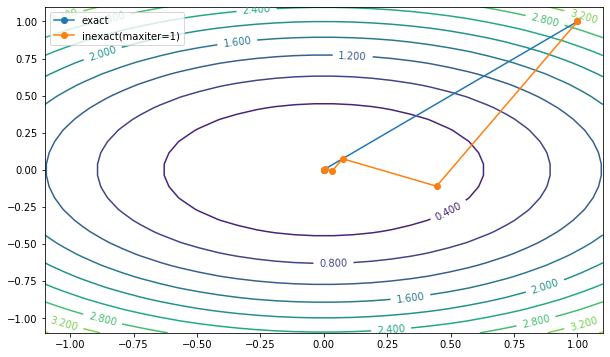

In [14]:
x, y, z = symbols('x y z')
variables = [x, y]

f = x**2 + 2*y**2

w, w_history1, _ = newton(f, variables, n_steps=2,  w=[1, 1], exact=True, verbose=0)

w, w_history2, _ = newton(f, variables, n_steps=5,  w=[1, 1], exact=False, maxiter=1, verbose=0)

plot_2d_contoursteps(f, variables, w_history1, w_history2)
plt.legend(['exact', 'inexact(maxiter=1)']);

## Same with more variables

In [15]:
variables = symbols('x:10')
f = sum([(i+1)*v**2 for i, v in enumerate(variables)])

print('answer',newton(f, variables, n_steps=2,  w=[1]*10, exact=True))

print('-'*100)

print('answer',newton(f, variables, n_steps=5,  w=[1]*10, exact=False, maxiter=2))

print('-'*100)

print('answer',newton(f, variables, n_steps=5,  w=[1]*10, exact=False, maxiter=10))

f_gradient [2*x0, 4*x1, 6*x2, 8*x3, 10*x4, 12*x5, 14*x6, 16*x7, 18*x8, 20*x9]
f_hessian [[2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 10, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 12, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 14, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 16, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 18, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 20]]
gradient [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
hessian [[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 14.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 16.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 18.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]]
step 0
w [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f 55.0000000000000
s [-1. -1. -1. -1. -1. -1. -1. -1. -

# Saddle point mitigation

#  *f = sum of cubic functions* Plot 2 from report


f_gradient [3*x0**2, 6*x1**2, 9*x2**2, 12*x3**2, 15*x4**2, 18*x5**2, 21*x6**2, 24*x7**2, 27*x8**2, 30*x9**2]
f_hessian [[6*x0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 12*x1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 18*x2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 24*x3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 30*x4, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 36*x5, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 42*x6, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 48*x7, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 54*x8, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 60*x9]]
gradient [ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30.]
hessian [[ 6.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 12.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 18.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 24.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 30.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 36.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 42.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 48.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 54.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 60.]]
step 0
w [1, 1, 1, 1, 1, 1, 1, 

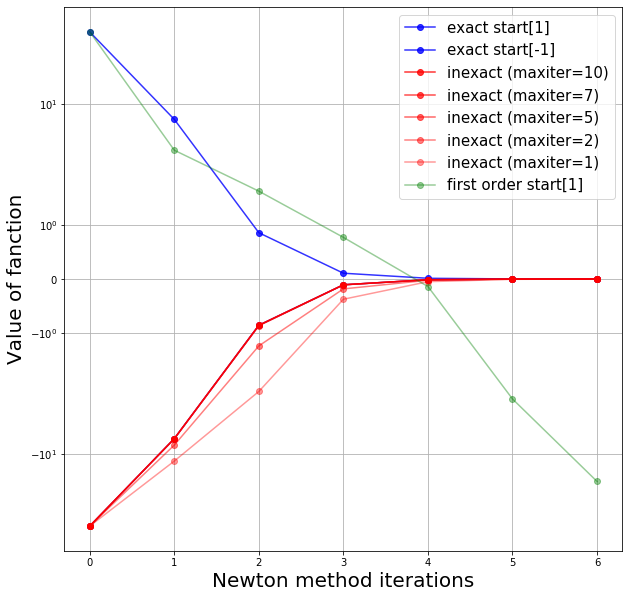

In [16]:
variables = symbols('x:10')
f = sum([(i+1)*v**3 for i, v in enumerate(variables)])

plt.figure(figsize=(10,10))
plt.grid()

#With exact method we stuck in saddle point doest matter where we start
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[1]*10, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)


#Same with inexact with big number of iterations
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=10)
plt.plot(f_history, '-o', color='red', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=7)
plt.plot(f_history, '-o', color='red', alpha=.7)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=5)
plt.plot(f_history, '-o', color='red', alpha=.6)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=2)
plt.plot(f_history, '-o', color='red', alpha=.5)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=1)
plt.plot(f_history, '-o', color='red', alpha=.4)

w, w_history, f_history = newton(f, variables, n_steps=6,  lr=0.04, order=1, w=[1]*10)
plt.plot(f_history, '-o', color='green', alpha=.4)



plt.yscale('symlog')
plt.xlabel('Newton method iterations', fontsize=20 )
plt.ylabel('Value of fanction', fontsize=20)
plt.legend(['exact start[1]', 
            'exact start[-1]',
            'inexact (maxiter=10)',
            'inexact (maxiter=7)',
            'inexact (maxiter=5)',
            'inexact (maxiter=2)',
            'inexact (maxiter=1)',
            'first order start[1]'], prop={'size': 15})

# Same experiment with parabolic function

f_gradient [2*x0, 4*x1, 6*x2, 8*x3, 10*x4, 12*x5, 14*x6, 16*x7, 18*x8, 20*x9]
f_hessian [[2, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 4, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 8, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 10, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 12, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 14, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 16, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 18, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 20]]
gradient [ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]
hessian [[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 14.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 16.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 18.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 20.]]
step 0
w [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
f 55.0000000000000
s [-1. -1. -1. -1. -1. -1. -1. -1. -

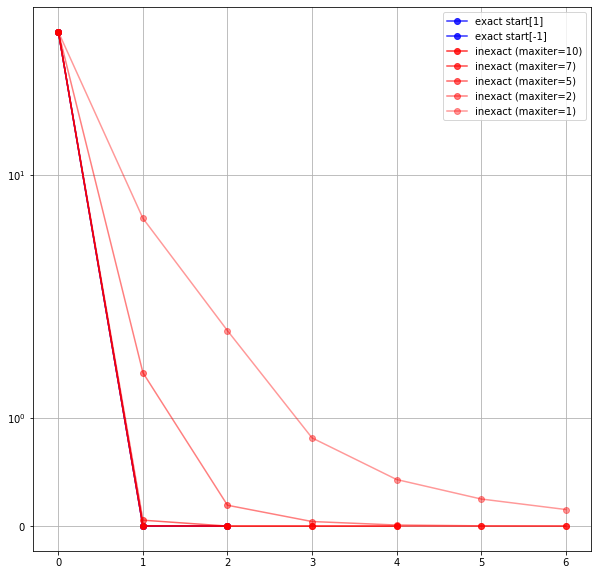

In [17]:
variables = symbols('x:10')
f = sum([(i+1)*v**2 for i, v in enumerate(variables)])

plt.figure(figsize=(10,10))
plt.grid()

iterations=10

#With exact method we stuck in saddle point doest matter where we start
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[1]*10, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)




#Same with inexact with big number of iterations
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=10)
plt.plot(f_history, '-o', color='red', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=7)
plt.plot(f_history, '-o', color='red', alpha=.7)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=5)
plt.plot(f_history, '-o', color='red', alpha=.6)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=2)
plt.plot(f_history, '-o', color='red', alpha=.5)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*10, exact=False, maxiter=1)
plt.plot(f_history, '-o', color='red', alpha=.4)


plt.yscale('symlog')
plt.legend(['exact start[1]', 
            'exact start[-1]',
            'inexact (maxiter=10)',
            'inexact (maxiter=7)',
            'inexact (maxiter=5)',
            'inexact (maxiter=2)',
            'inexact (maxiter=1)'])

# Different saddle points experiments

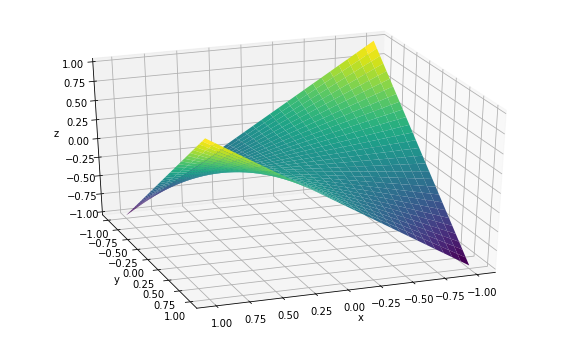

In [18]:
from mpl_toolkits import mplot3d
from sympy.utilities.lambdify import lambdify

def ff(x, y):
      return np.sin(np.sqrt(x ** 2 + y ** 2))

def plot_2d_func(func, variables, view_x, view_y, x_min=-1, x_max=1, y_min=-1, y_max=1):

  f = lambdify(variables, func, 'numpy')


  x = np.linspace(x_min, x_max, 30)
  y = np.linspace(y_min, y_max, 30)

  X, Y = np.meshgrid(x, y)
  Z = f(X, Y)

  fig = plt.figure(figsize=(10,6))

  ax = plt.axes(projection='3d')
  ax.view_init(view_x, view_y)

  ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

  
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');
  plt.show()


x, y, z = symbols('x y z')
variables = [x, y]
f = x*y

plot_2d_func(f, variables, 30, 70)

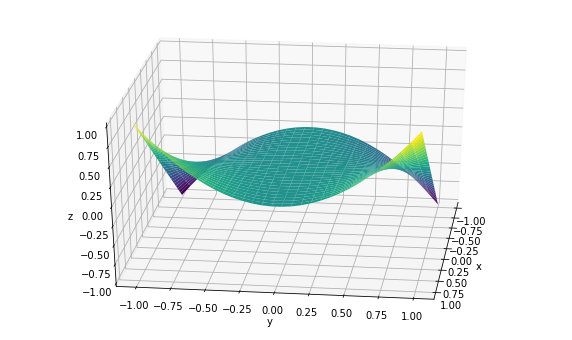

In [19]:
x, y, z = symbols('x y z')
variables = [x, y]
f = x*y**2

plot_2d_func(f, variables, 30, 7)

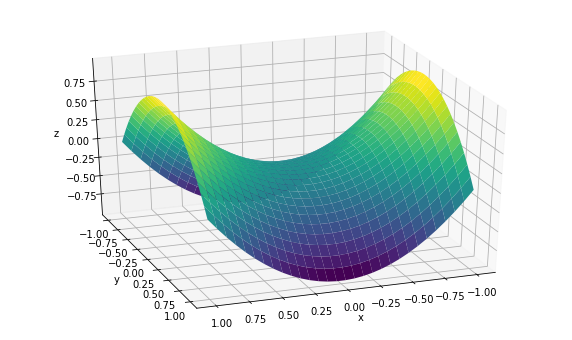

In [20]:
x, y, z = symbols('x y z')
variables = [x, y]
f = x**2 - y**2

plot_2d_func(f, variables, 30, 70)

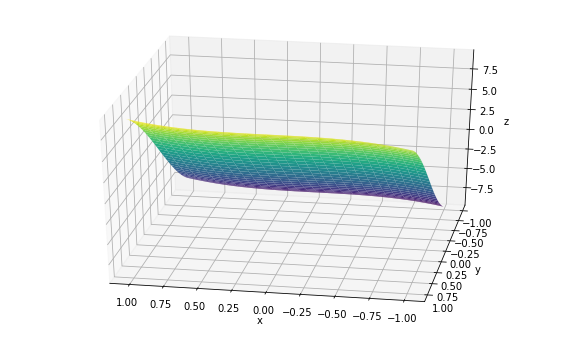

In [21]:
x, y, z = symbols('x y z')
variables = [x, y]
f = x**3 + 10*sin(y)

plot_2d_func(f, variables, 30, 100)

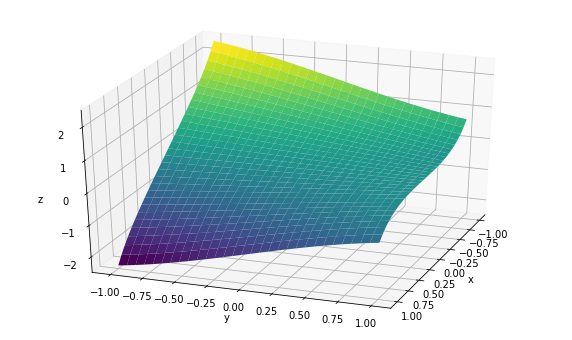

In [22]:
x, y, z = symbols('x y z')
variables = [x, y]
f = sin(x*y) - tan(x)

plot_2d_func(f, variables, 30, 20)

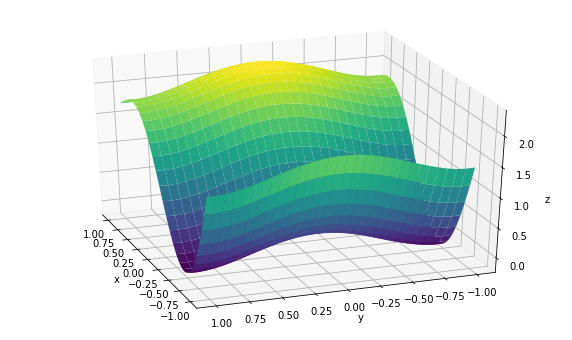

In [23]:
x, y, z = symbols('x y z')
variables = [x, y]
f = sin(3*x) + cos(2*y) + x**2 + y**2

plot_2d_func(f, variables, 30, 160)

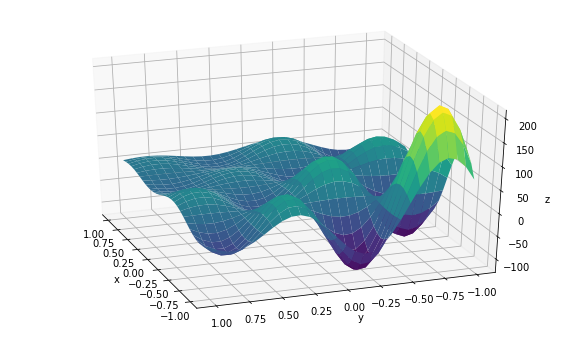

In [24]:
x, y = symbols('x y')
variables = [x, y]
f = sum([i*cos((i + 1)*x + i) for i in range(1,6)])* sum([i*cos((i + 1)*y + i) for i in range(1,6)])

plot_2d_func(f, variables, 30, 160, x_min=-1, x_max=1, y_min=-1, y_max=1)

# Monkey saddle point

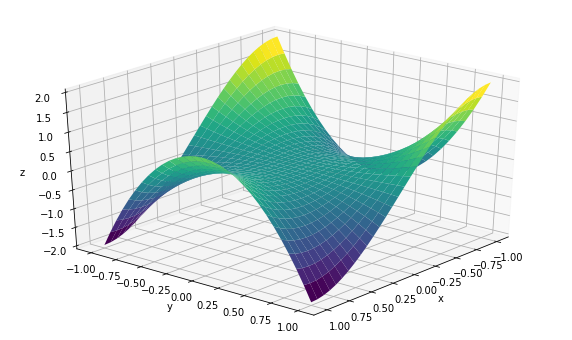

In [25]:
x, y, z = symbols('x y z')
variables = [x, y]
f = (x**3 - 3*x*y**2)

plot_2d_func(f, variables, 30, 40)

f_gradient [3*x**2 - 3*y**2, -6*x*y]
f_hessian [[6*x, -6*y], [-6*y, -6*x]]
gradient [ 4.72728505e-125 -6.00000000e+000]
hessian [[ 6. -6.]
 [-6. -6.]]
step 0
w [1, 1]
f -2.00000000000000
s [-0.5 -0.5]
gradient [ 1.18182126e-125 -1.50000000e+000]
hessian [[ 3. -3.]
 [-3. -3.]]
step 1
w [0.5 0.5]
f -0.250000000000000
s [-0.25 -0.25]
gradient [ 2.95455316e-126 -3.75000000e-001]
hessian [[ 1.5 -1.5]
 [-1.5 -1.5]]
step 2
w [0.25 0.25]
f -0.0312500000000000
s [-0.125 -0.125]
gradient [ 7.38638289e-127 -9.37500000e-002]
hessian [[ 0.75 -0.75]
 [-0.75 -0.75]]
step 3
w [0.125 0.125]
f -0.00390625000000000
s [-0.0625 -0.0625]
gradient [ 1.84659572e-127 -2.34375000e-002]
hessian [[ 0.375 -0.375]
 [-0.375 -0.375]]
step 4
w [0.0625 0.0625]
f -0.000488281250000000
s [-0.03125 -0.03125]
gradient [ 4.61648931e-128 -5.85937500e-003]
hessian [[ 0.1875 -0.1875]
 [-0.1875 -0.1875]]
step 5
w [0.03125 0.03125]
f -6.10351562500000e-5
s [-0.015625 -0.015625]
f_gradient [3*x**2 - 3*y**2, -6*x*y]
f_hessian [[6*

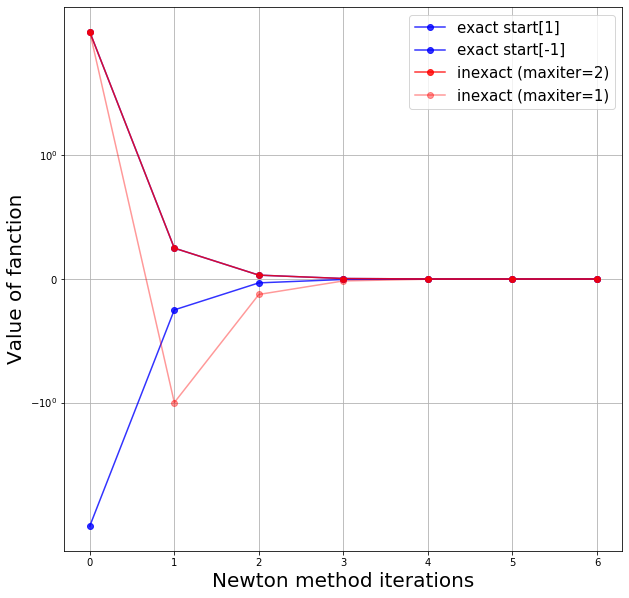

In [26]:
x, y, z = symbols('x y z')
variables = [x, y]
f = (x**3 - 3*x*y**2)

plt.figure(figsize=(10,10))
plt.grid()

#With exact method we stuck in saddle point doest matter where we start
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[1]*2, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*2, exact=True)
plt.plot(f_history, '-o', color='b', alpha=.8)


#Same with inexact with big number of iterations
w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*2, exact=False, maxiter=2)
plt.plot(f_history, '-o', color='red', alpha=.8)

w, w_history, f_history = newton(f, variables, n_steps=6,  w=[-1]*2, exact=False, maxiter=1)
plt.plot(f_history, '-o', color='red', alpha=.4)

# w, w_history, f_history = newton(f, variables, n_steps=6,  lr=0.04, order=1, w=[-1]*2)
# plt.plot(f_history, '-o', color='green', alpha=.4)

plt.yscale('symlog')
plt.xlabel('Newton method iterations', fontsize=20 )
plt.ylabel('Value of fanction', fontsize=20)
plt.legend(['exact start[1]', 
            'exact start[-1]',
            'inexact (maxiter=2)',
            'inexact (maxiter=1)',
            'first order start[1]'], prop={'size': 15})

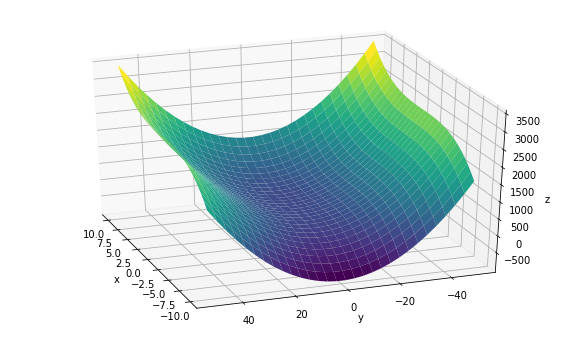

In [27]:
x, y = symbols('x y')
variables = [x, y]
f = x**3 + y**2

plot_2d_func(f, variables, 30, 160, x_min=-10, x_max=10, y_min=-50, y_max=50)

# Evaluation of premature stop

In [0]:
from tqdm import tqdm

2
11
4
11
6
11
8
11
10
11
12
11
14
11
16
11
18
11
20
11


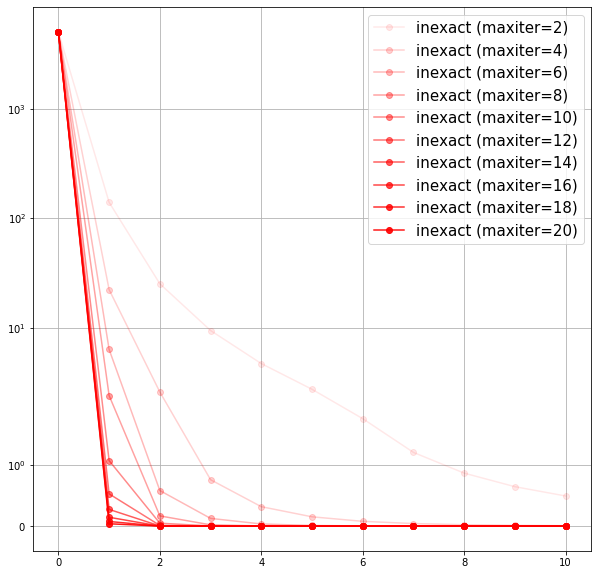

In [29]:
variables = symbols('x:100')

f = sum([(i+1)*v**2 for i, v in enumerate(variables)])

plt.figure(figsize=(10,10))
plt.grid()

steps = []
f_histories = []

maxiters = range(2, 22, 2)

for maxiter in maxiters:
  w, w_history, f_history = newton(f, variables, n_steps=10, w=[1.0]*100, lr=1.0, exact=False, maxiter=maxiter, tol=0, verbose=0)
  print(maxiter)
  print(len(f_history))
  steps.append(len(f_history))
  f_histories.append(f_history.copy())
  plt.plot(f_history, '-o', color='red', alpha=maxiter/22)

plt.yscale('symlog')
plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

# Plot 3 from report (Cilville function)

1
31
[1.53112425 2.15923416 1.50143249 2.15625572]
2
31
[1.03247456 1.06597283 0.9667352  0.93393191]
3
31
[1.06974505 1.14450444 0.92750298 0.85951856]
4
31
[1. 1. 1. 1.]


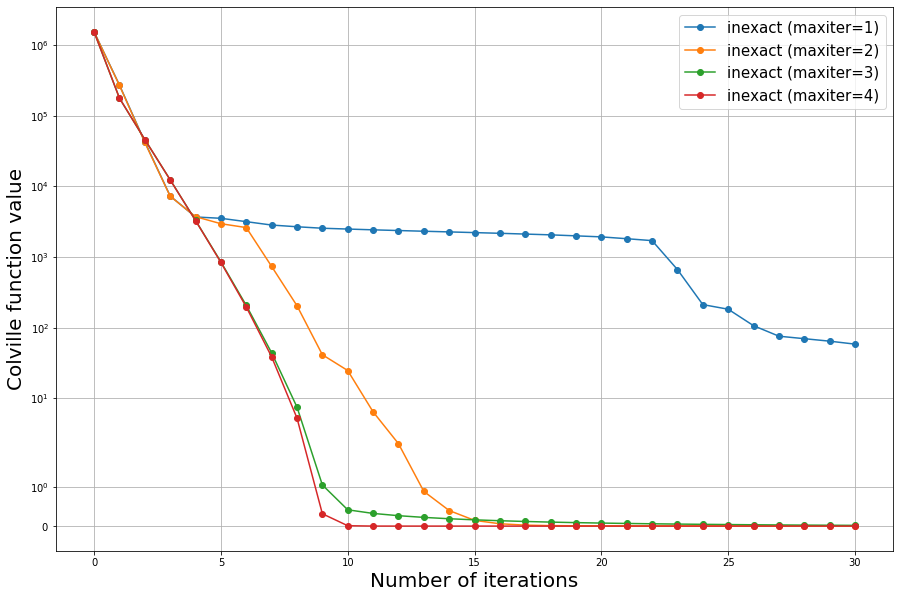

In [30]:
variables = symbols('x:4')
x1, x2, x3, x4 = variables
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2 + (x3 - 1)**2 + 90*(x3**2 -x4)**2 + 10.1*((x2-1)**2 + (x4-1)**2) + 19.8*(x2 - 1)*(x4 - 1)


maxiters = range(1, 5)
w = [10]*len(variables)
n_steps = 30


plt.figure(figsize=(15,10))
plt.grid()

steps = []
f_histories = []

for maxiter in maxiters:
  finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=0, verbose=0)
  print(maxiter)
  print(len(f_history))
  steps.append(len(f_history))
  f_histories.append(f_history.copy())
  print(finded_w)
  plt.plot(f_history, '-o')
  
    


plt.yscale('symlog')
plt.xlabel('Number of iterations', fontsize=20 )

plt.ylabel('Colville function value', fontsize=20)
plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

# Now lets count how many steps we need to get to specified tollerance

# Tollerance = 1e-6

1
135
[1.00104356 1.00210496 0.9993363  0.99865465]
2
161
[1.00225749 1.00451461 0.99775989 0.99547415]
3
55
[1.00001392 1.00002788 0.99998596 0.99997187]
4
15
[1. 1. 1. 1.]


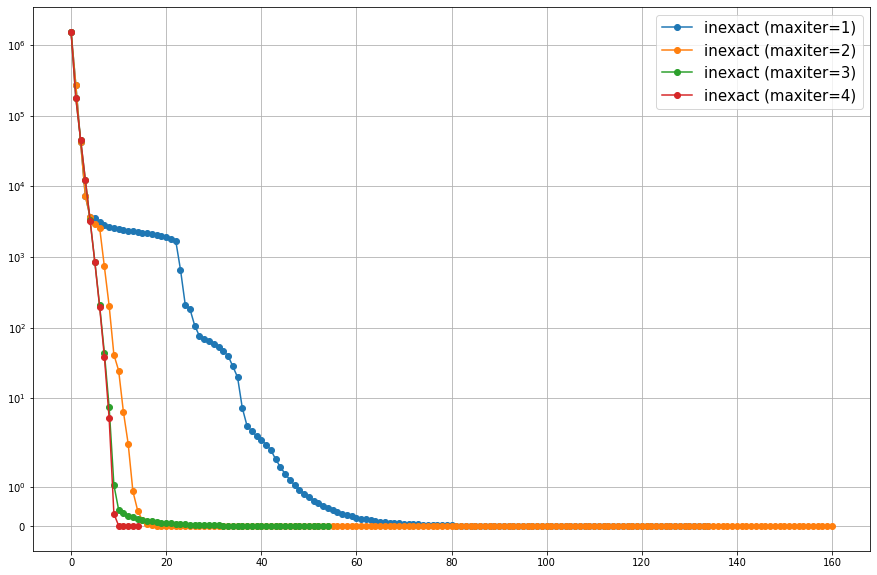

In [31]:
variables = symbols('x:4')
x1, x2, x3, x4 = variables
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2 + (x3 - 1)**2 + 90*(x3**2 -x4)**2 + 10.1*((x2-1)**2 + (x4-1)**2) + 19.8*(x2 - 1)*(x4 - 1)


maxiters = range(1, 5)
w = [10]*len(variables)
n_steps = 30000


plt.figure(figsize=(15,10))
plt.grid()

steps = []
f_histories = []

for maxiter in maxiters:
  finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=1e-6, verbose=0)
  print(maxiter)
  print(len(f_history))
  steps.append(len(f_history))
  f_histories.append(f_history.copy())
  print(finded_w)
  plt.plot(f_history, '-o')
  
    


plt.yscale('symlog')
plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

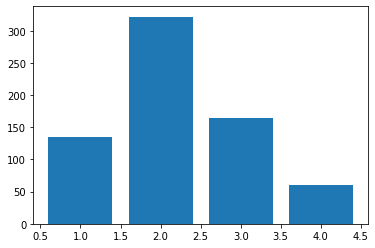

In [32]:
total_cg_iterations = np.array(steps) * np.array(maxiters)

plt.bar(maxiters, total_cg_iterations);

# Now lets do the same for different tollerace values

In [33]:
variables = symbols('x:4')
x1, x2, x3, x4 = variables
f = 100*(x1**2 - x2)**2 + (x1 - 1)**2 + (x3 - 1)**2 + 90*(x3**2 -x4)**2 + 10.1*((x2-1)**2 + (x4-1)**2) + 19.8*(x2 - 1)*(x4 - 1)


maxiters = range(1, 5)
w = [10]*len(variables)
n_steps = 30000

f_histories = []


steps_with_different_tols = []
for tol in [1e-3,1e-4, 1e-5,1e-6,1e-7]:
  steps = []
  for maxiter in maxiters:
    finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=tol, verbose=0)
    print(maxiter)
    print(len(f_history))
    steps.append(len(f_history))
    f_histories.append(f_history.copy())
    print(finded_w)
    print(f_history[-1])
  steps_with_different_tols.append(steps.copy())

1
88
[1.00764618 1.01303422 1.00510619 1.00966292]
0.00580375343978985
2
22
[1.03771234 1.07558874 0.96290819 0.92756   ]
0.00525889054969702
3
39
[1.03740387 1.07628949 0.96238096 0.92580773]
0.00513566432892688
4
13
[1.0011137  1.00213212 0.99897919 0.99789225]
5.42335655339250e-6
1
104
[1.0030206  1.00530453 1.00099139 1.00179897]
0.000574627253507584
2
37
[1.02977363 1.06040294 0.96958718 0.93950512]
0.00330499037426994
3
53
[1.00498509 1.0100057  0.99513955 0.99026898]
8.82973172205279e-5
4
14
[1.00000996 1.00001865 0.99999127 0.99998154]
5.66853452341287e-10
1
120
[1.00153273 1.00283794 0.99970309 0.99934703]
5.69968428603058e-5
2
110
[1.00765718 1.01515392 0.99234252 0.98482078]
0.000214619842513138
3
55
[1.00001392 1.00002788 0.99998596 0.99997187]
7.05750480693577e-10
4
14
[1.00000996 1.00001865 0.99999127 0.99998154]
5.66853452341287e-10
1
135
[1.00104356 1.00210496 0.9993363  0.99865465]
8.54857011123254e-6
2
161
[1.00225749 1.00451461 0.99775989 0.99547415]
1.85224441428342

In [34]:
steps_with_different_tols

[[88, 22, 39, 13],
 [104, 37, 53, 14],
 [120, 110, 55, 14],
 [135, 161, 55, 15],
 [151, 206, 55, 15]]

In [35]:
maxiters

range(1, 5)

# Plotting

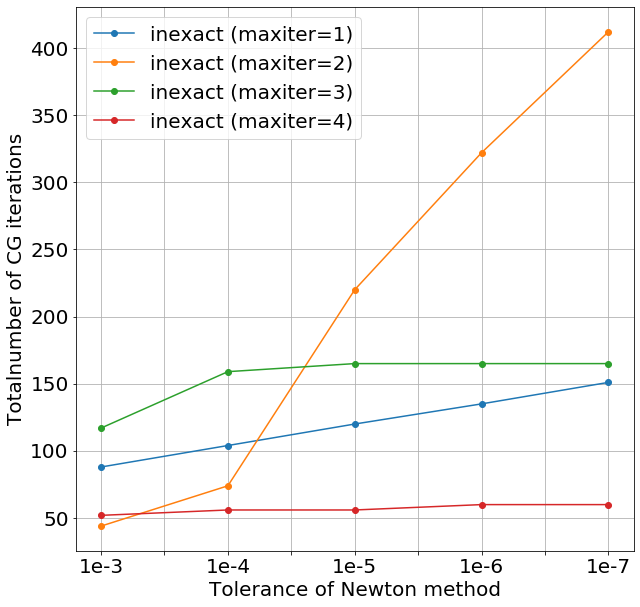

In [36]:
steps = np.array(steps_with_different_tols).T


fig, ax = plt.subplots(figsize=(10,10))

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
for i in range(4):
  ax.plot(steps[i]*(i+1), '-o')

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '1e-3'
labels[2] = ''
labels[3] = '1e-4'
labels[4] = ''
labels[5] = '1e-5'
labels[6] = ''
labels[7] = '1e-6'
labels[8] = ''
labels[9] = '1e-7'

ax.tick_params(axis='both', labelsize=20)
ax.set_xticklabels(labels)
ax.set_xlabel('Tolerance of Newton method', fontsize=20)
ax.set_ylabel('Totalnumber of CG iterations', fontsize=20)


plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 20});
plt.grid()
plt.show()

# Now with other functions

# Parabolic

1
1114
[ 1.10581736e-002  1.19982447e-004  1.33336526e-008  1.30130141e-016
  4.64222091e-033  8.10381268e-068  2.24684357e-146  0.00000000e+000
  0.00000000e+000 -1.77627120e-005]
2
241
[ 4.50236157e-003  1.83720923e-005  2.24030103e-010  8.40843186e-021
  1.22545936e-044  7.76900430e-114 -1.00520991e-167 -3.96841755e-005
  3.23939105e-011  1.42479132e-005]
3
108
[ 2.80692447e-03  6.16845857e-06  1.29053509e-11  7.32826988e-25
  3.01348059e-67  1.54487430e-52  6.10370430e-05 -3.97909345e-46
  7.00407748e-06 -2.75547446e-07]
4
53
[ 1.62596848e-03  1.43218884e-06  8.81233401e-14  9.26601968e-39
 -6.99564336e-23 -5.71965224e-05  8.42290854e-47  6.80116646e-06
  1.09931747e-05  1.29306783e-05]
5
23
[ 7.68366559e-04  5.70443899e-08 -5.19759454e-31 -8.38391050e-07
 -6.75796371e-05 -8.26612518e-13 -3.36549910e-06  6.84064409e-06
  9.34643098e-06  1.04808508e-05]
6
16
[ 5.78709035e-04  3.81529699e-09  2.97984744e-10  9.77803260e-05
 -1.98861851e-12 -3.20560884e-05 -1.45698452e-05  1.66916223e

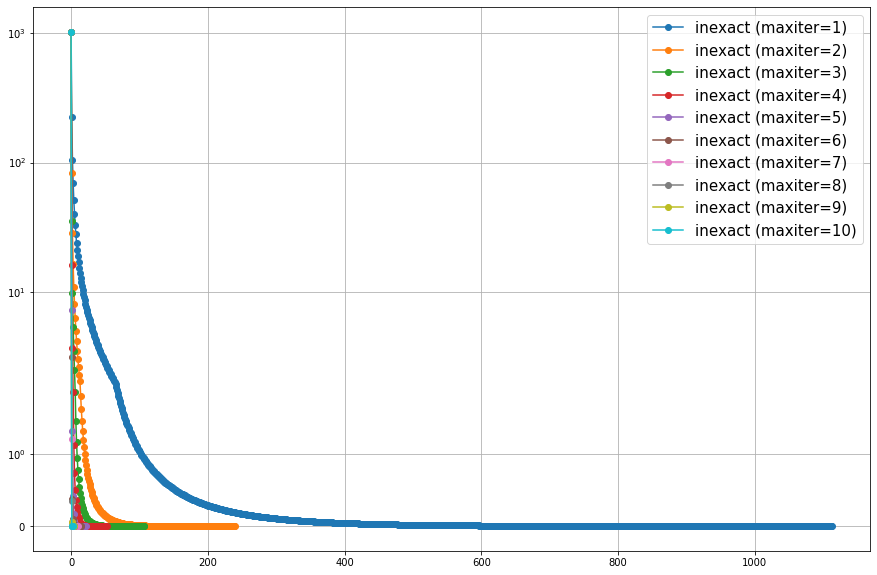

In [37]:
variables = symbols('x:10')
f = sum([(2**i)*v**(2) for i, v in enumerate(variables)])


maxiters = range(1, 11)
w = [1]*len(variables)
n_steps = 3000


plt.figure(figsize=(15,10))
plt.grid()

steps = []
f_histories = []

for maxiter in maxiters:
  finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=1e-6, verbose=0)
  print(maxiter)
  print(len(f_history))
  steps.append(len(f_history))
  f_histories.append(f_history.copy())
  print(finded_w)
  plt.plot(f_history, '-o')
  
    


plt.yscale('symlog')
plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

In [38]:
steps

[1114, 241, 108, 53, 23, 16, 11, 6, 5, 4]

In [39]:
np.array(steps)* np.array(maxiters)

array([1114,  482,  324,  212,  115,   96,   77,   48,   45,   40])

# Differenr dgrees, we will stop in saddle point (zero)

2
11
[ 8.29406074e-01  6.85962310e-01  4.65036156e-01  2.05566860e-01
  3.32853487e-02  2.59210137e-04 -3.01920704e-10 -1.37500562e-02
  1.00903000e-02  1.48645486e-02]
4
11
[ 3.29701505e-01  9.88212834e-02  6.04698136e-03  8.34110064e-07
 -1.23834204e-05 -1.35098830e-02 -4.44126496e-12  1.60109150e-03
  2.58658831e-03  3.04167293e-03]
6
11
[ 7.23642314e-03  2.53243592e-06 -7.19056645e-07 -1.07289477e-03
  3.45595133e-08 -1.17450662e-04  2.55444583e-05  7.52754735e-05
  9.74579056e-05  1.08030010e-04]
8
6
[ 9.43746892e-05  1.99861559e-05 -6.91432721e-06 -1.34844231e-05
 -8.45452870e-06  8.01787670e-08 -9.58398471e-10  6.09546432e-12
 -1.60684928e-14 -8.50151228e-13]
10
4
[ 5.51214509e-14 -2.75608310e-14  4.59354248e-15 -3.28130545e-16
  1.09400393e-17 -1.64767761e-19 -1.47630181e-19 -7.33153791e-18
 -3.63870820e-19  1.12658615e-12]
2
11
[0.54330209 0.49821708 0.4568687  0.41895082 0.38417969 0.35229435
 0.32305535 0.29624307 0.27165609 0.30973073]
4
11
[0.45985455 0.42169746 0.38670174

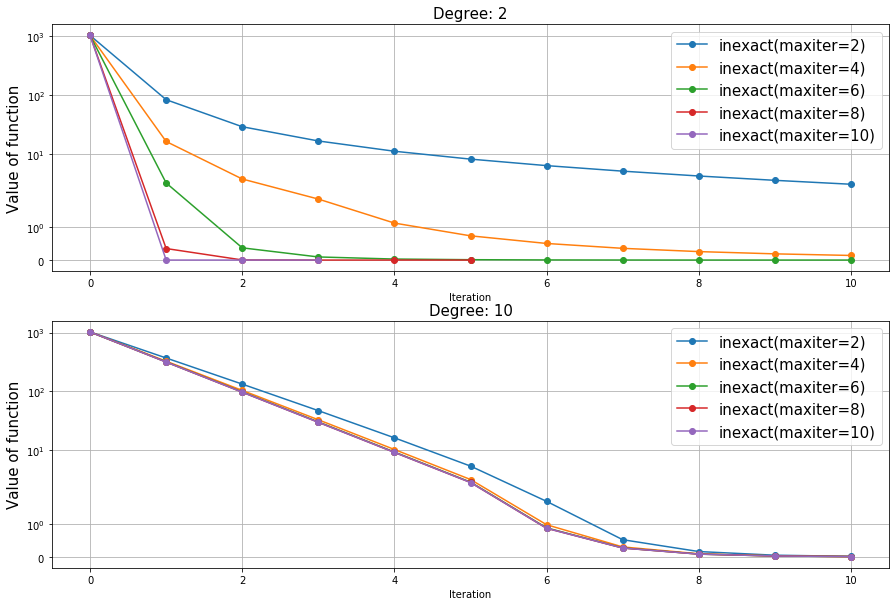

In [40]:

fig, ax = plt.subplots(2, figsize=(15,10))

# plt.grid()

for i, degree in enumerate([2, 10]):
  variables = symbols('x:10')
  f = sum([(2**i)*v**(degree) for i, v in enumerate(variables)])


  maxiters = range(2, 12, 2)
  w = [1]*len(variables)
  n_steps = 10

  steps = []
  f_histories = []

  for maxiter in maxiters:
    finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=1e-6, verbose=0)
    print(maxiter)
    print(len(f_history))
    steps.append(len(f_history))
    f_histories.append(f_history.copy())
    print(finded_w)
    ax[i].plot(f_history, '-o')
    
      

  ax[i].grid()
  ax[i].set_xlabel('Iteration', fontsize=10)
  ax[i].set_ylabel('Value of function', fontsize=15)
  ax[i].set_yscale('symlog')
  ax[i].set_title(f'Degree: {degree}', fontsize=15)
  ax[i].legend([f'inexact(maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

1
2817
[1.10308904e-005 1.15954195e-010 1.10687207e-020 5.54953037e-041
 1.15359839e-082 9.31620594e-171 4.94065646e-324 0.00000000e+000
 0.00000000e+000 2.62027535e-008]
2
545
[ 4.50211751e-006  1.61824139e-011  1.02461928e-022  1.75500761e-046
  7.39094797e-101  4.26667184e-259  0.00000000e+000 -3.96807031e-008
  5.61406540e-023  1.42466693e-008]
3
232
[ 2.75903391e-006  4.44622671e-012  1.83465045e-024  2.17391246e-053
  1.59355820e-146  2.01075850e-110  5.99950814e-008 -7.08606551e-097
  6.88451186e-009 -2.70843620e-010]
4
107
[ 1.73154797e-06  8.31758747e-13  9.41617665e-28  4.57722320e-80
 -6.71659890e-45 -6.09103885e-08 -5.10910341e-91  7.24277788e-09
  1.17069804e-08  1.37702895e-08]
5
44
[ 7.80090361e-07  6.92157966e-15 -1.31292218e-59  7.86417624e-13
  5.64415298e-08 -2.04998939e-24 -4.08462679e-08 -1.86914671e-09
  3.97443235e-11 -3.05643551e-13]
6
30
[ 4.94480517e-07  5.21575460e-17  6.60574016e-20  8.35488359e-08
 -2.43904685e-24 -2.73904678e-08 -1.24492692e-08  1.42622312

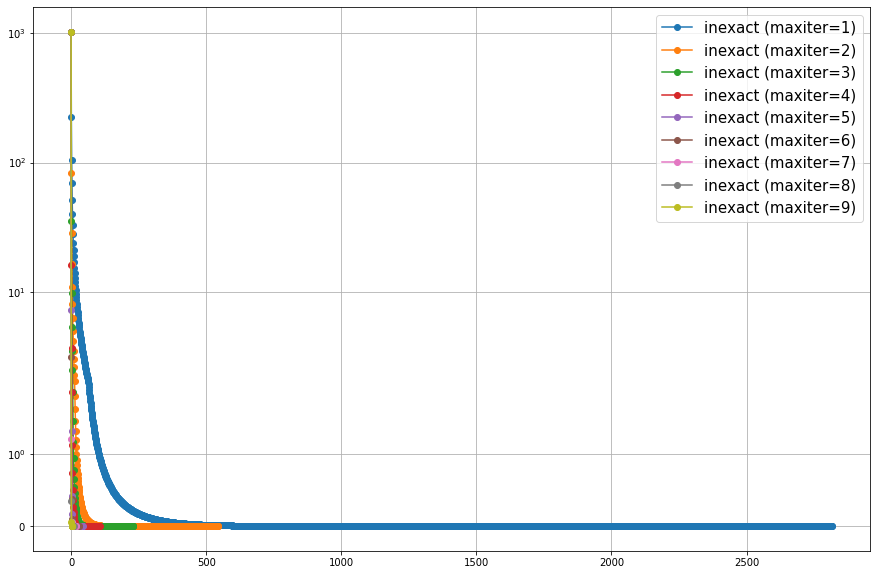

In [41]:
variables = symbols('x:10')
f = sum([(2**i)*v**(2) for i, v in enumerate(variables)])


maxiters = range(1, 10)
w = [1]*len(variables)
n_steps = 30000


plt.figure(figsize=(15,10))
plt.grid()

steps = []
f_histories = []

for maxiter in maxiters:
  finded_w, w_history, f_history = newton(f, variables, n_steps=n_steps, w=w, lr=1.0, exact=False, maxiter=maxiter, tol=1e-12, verbose=0)
  print(maxiter)
  print(len(f_history))
  steps.append(len(f_history))
  f_histories.append(f_history.copy())
  print(finded_w)
  plt.plot(f_history, '-o')
  
    


plt.yscale('symlog')
plt.legend([f'inexact (maxiter={maxiter})' for maxiter in  maxiters], prop={'size': 15});

In [42]:
steps
np.array(steps)* np.array(maxiters)

array([2817, 1090,  696,  428,  220,  180,  133,   80,   54])

# Working with Linear regression

In [43]:
from sklearn.datasets import make_regression

X, y, ans = make_regression(n_samples=5, n_features=5, coef=True)
n, m = X.shape

w = symbols(f'w:{X.shape[1]}')

def h(w, x):
  return sum([w[i]*x[i] for i in range(m)])


def mse():
  return sum([(h(w, X[i]) - y[i])**2 for i in range(n)])/n

mse()

(-0.134841384752288*w0 - 0.0731421179381078*w1 + 0.774152273514151*w2 - 0.422063086474037*w3 + 0.32502853470744*w4 - 27.1490354674847)**2/5 + (-0.0279011352624031*w0 - 0.902614878804238*w1 + 0.118779075812308*w2 - 0.623876637251474*w3 - 0.557789504889897*w4 + 98.0331145360657)**2/5 + (0.152859073920771*w0 + 3.27678290393182*w1 - 0.0865046802141893*w2 + 0.342337810192317*w3 - 1.75613354951028*w4 - 200.887071366963)**2/5 + (0.161456918601643*w0 - 1.08874032841723*w1 + 1.1894804141268*w2 + 0.304268235387944*w3 + 0.895335082977963*w4 - 28.1974626019515)**2/5 + (0.996921234747137*w0 + 0.673532770760512*w1 + 0.859484633027169*w2 + 0.0547777477723289*w3 - 0.47333507215735*w4 - 97.0736819264282)**2/5

In [44]:
X

array([[ 0.15285907,  3.2767829 , -0.08650468,  0.34233781, -1.75613355],
       [-0.02790114, -0.90261488,  0.11877908, -0.62387664, -0.5577895 ],
       [ 0.16145692, -1.08874033,  1.18948041,  0.30426824,  0.89533508],
       [-0.13484138, -0.07314212,  0.77415227, -0.42206309,  0.32502853],
       [ 0.99692123,  0.67353277,  0.85948463,  0.05477775, -0.47333507]])

In [45]:
y

array([200.88707137, -98.03311454,  28.1974626 ,  27.14903547,
        97.07368193])

In [46]:
loss = simplify(mse())
loss

0.212449370744971*w0**2 + 0.412642810923976*w0*w1 + 0.371185385227135*w0*w2 + 0.0921532759080027*w0*w3 - 0.249610010524031*w0*w4 - 52.443729446077*w0 + 2.6392742968731*w1**2 - 0.465374474263834*w1*w2 + 0.568553246754919*w1*w3 - 2.62734666242156*w1*w4 - 311.778528871981*w1 + 0.554896152227607*w2**2 - 0.00858266882910783*w2*w3 + 0.398176381126697*w2*w4 - 43.5876801198944*w2 + 0.156026848895314*w3**2 - 0.0575551292425203*w3*w4 - 52.9481096367096*w3 + 0.905289745040061*w4**2 + 123.99226910981*w4 + 12184.3147469587

In [0]:
w, _, _ = newton(loss, w, n_steps=2, lr=1.0, exact=False, verbose=0)

# Anser and finded w are the same.

In [48]:
w

array([ 8.7959055 , 70.40810564, 57.72703191, 44.74266802, 23.6274673 ])

In [49]:
ans

array([ 8.7959055 , 70.40810564, 57.72703191, 44.74266802, 23.6274673 ])